In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
train_df = pd.read_csv('train_dataset1.csv')
train_df['filename'] = train_df['filename'].str.replace(r'.xml', '.png')

In [ ]:
WIDTH = 224
HEIGHT = 224

In [ ]:
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col="filename",
    y_col=["x_max", "y_max", "x_min", "y_min"],
    target_size=(WIDTH, HEIGHT),
    class_mode="raw",
    batch_size=16)

Found 400 validated image filenames.


In [ ]:
model = Sequential()
model.add(ResNet50(weights="imagenet", include_top=False, input_shape = (224,224,3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# We have to make first layers untrainable
model.layers
model.layers[0].trainable=False

In [ ]:
model.layers

In [ ]:
# TRAINING PARAMS
step_size = 400/16
step_size = 25
# smaller learning rate than default 0.001
model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")

In [ ]:
history = model.fit_generator(train_generator,
    steps_per_epoch=step_size,
    epochs=30)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 73s 3s/step - loss: 0.0903
Epoch 2/30
25/25 [==============================] - 69s 3s/step - loss: 0.0837
Epoch 3/30
25/25 [==============================] - 69s 3s/step - loss: 0.0628
Epoch 4/30
25/25 [==============================] - 68s 3s/step - loss: 0.0611
Epoch 5/30
25/25 [==============================] - 69s 3s/step - loss: 0.0670
Epoch 6/30
25/25 [==============================] - 68s 3s/step - loss: 0.0501
Epoch 7/30
25/25 [==============================] - 68s 3s/step - loss: 0.0174
Epoch 8/30
25/25 [==============================] - 68s 3s/step - loss: 0.0152
Epoch 9/30
25/25 [==============================] - 69s 3s/step - loss: 0.0157
Epoch 10/30
25/25 [==============================] - 69s 3s/step - loss: 0.0133
Epoch 11/30
25/25 [==============================] - 68s 3s/step - loss: 0.0129
Epoch 12/30
25/25 [==============================] - 69s 3s/step - loss: 0.0144
Epoch 13/30
25/25 [==============================

In [ ]:
model.save('.')

INFO:tensorflow:Assets written to: ./assets


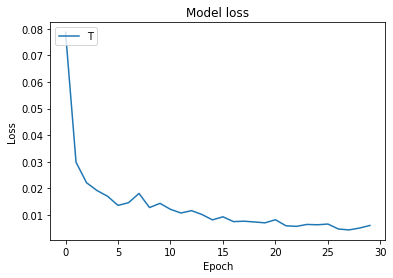

In [21]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

In [22]:
test_df = pd.read_csv('test_dataset1.csv')
test_df['filename'] = test_df['filename'].str.replace(r'.xml', '.png')

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=None,
    x_col="filename",
    y_col=["x_max", "y_max", "x_min", "y_min"],
    target_size=(WIDTH, HEIGHT),
    class_mode="raw",
    batch_size=1)

Found 33 validated image filenames.


In [25]:
test_history = model.evaluate(test_generator)

33/33 [==============================] - 2s 17ms/step - loss: 0.0153


In [32]:
# check sample prediciton

img = cv2.resize(cv2.imread("Cars431.png") / 255.0, dsize=(224, 224))
y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * 224

x_max, y_max = y_hat[0], y_hat[1]
x_min, y_min = y_hat[2], y_hat[3]

img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
image = cv2.rectangle(img, (x_max, y_max), (x_min, y_min), (0, 0, 255), 1)

filename_to_save = 'test_431.png'
cv2.imwrite(filename_to_save, image)

True